<a href="https://colab.research.google.com/github/yuvalira/Adversarial-Attacks-Article/blob/main/models/TabPFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Foundation Model — TabPFN**
TabPFN is a pretrained transformer for tabular data that approximates Bayesian inference in one forward pass.
We’ll use the local Python package `tabpfn` and its scikit-learn-style `TabPFNClassifier`.

References:
- PyPI: `tabpfn`
- GitHub: PriorLabs/TabPFN
- Tutorial: PriorLabs (AutoTabPFNClassifier, ensembles)

## Install & imports

In [1]:
!pip -q install -U tabpfn scikit-learn huggingface_hub

import os, re, time
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, classification_report, confusion_matrix)


# TabPFN (local sklearn-like API)
from tabpfn import TabPFNClassifier
# If you later want ensembling: from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 13.8 MB/s eta 0:00:00


## Load splits from HF

In [2]:
repo_id, repo_type = "yuvalira/adult_income_balanced", "dataset"  # TODO
def read_csv(repo_id, filename, repo_type="dataset"):
    p = hf_hub_download(repo_id=repo_id, filename=filename, repo_type=repo_type, token=False)
    return pd.read_csv(p)

train_data = read_csv(repo_id, "train.csv", repo_type)
val_data   = read_csv(repo_id, "val.csv",   repo_type)
print("Train:", train_data.shape, "| Val:", val_data.shape)

train.csv: 0.00B [00:00, ?B/s]

val.csv: 0.00B [00:00, ?B/s]

Train: (11687, 14) | Val: (2337, 14)


## Columns & config

In [3]:
auto_num = train_data.select_dtypes(include=['int16','int32','int64','float16','float32','float64']).columns.tolist()
auto_cat = train_data.select_dtypes(include=['object','category','bool']).columns.tolist()

TARGET_COLUMN_NAME   = "income"               # TODO
TARGET_LABELS        = ["<=50K", ">50K"]      # TODO
SAMPLE_WEIGHT_COLUMN = None

NUMERIC_FEATURE_NAMES     = [c for c in auto_num if c != TARGET_COLUMN_NAME]
CATEGORICAL_FEATURE_NAMES = [c for c in auto_cat if c != TARGET_COLUMN_NAME]

label2id = {lbl:i for i,lbl in enumerate(TARGET_LABELS)}
id2label = {i:lbl for lbl,i in label2id.items()}

## Prepare data (map target, encode missing/categorical)

In [4]:
def prepare_map_target(df):
    df = df.copy()
    df[TARGET_COLUMN_NAME] = df[TARGET_COLUMN_NAME].map(label2id)
    if df[TARGET_COLUMN_NAME].isna().any():
        raise ValueError("Unmapped targets—check TARGET_LABELS.")
    # Cast cats to str so encoder sees all categories
    for c in CATEGORICAL_FEATURE_NAMES:
        if c in df.columns: df[c] = df[c].astype(str)
    return df

train_data = prepare_map_target(train_data)
val_data   = prepare_map_target(val_data)
n_classes  = train_data[TARGET_COLUMN_NAME].nunique()
avg_mode   = None if n_classes==2 else "macro"

# TabPFN expects numeric features; we’ll impute numerics and ordinal-encode categoricals (no target leakage).
numeric = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])
pre = ColumnTransformer([
    ("num", numeric, NUMERIC_FEATURE_NAMES),
    ("cat", categorical, CATEGORICAL_FEATURE_NAMES),
])

Xtr_raw = train_data.drop(columns=[TARGET_COLUMN_NAME])
ytr     = train_data[TARGET_COLUMN_NAME].values
Xva_raw = val_data.drop(columns=[TARGET_COLUMN_NAME])
yva     = val_data[TARGET_COLUMN_NAME].values

Xtr = pre.fit_transform(Xtr_raw)   # fit on train
Xva = pre.transform(Xva_raw)       # transform val

## Define & Train TabPFN

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from tabpfn import TabPFNClassifier
clf_tabpfn = TabPFNClassifier(device="cuda")

MAX_N = 10_000
if len(ytr) > MAX_N:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=MAX_N, random_state=42)
    idx_sub, _ = next(sss.split(Xtr, ytr))
    Xtr_sub = Xtr[idx_sub]
    ytr_sub = ytr[idx_sub]
    if SAMPLE_WEIGHT_COLUMN:
        sw_tr_sub = train_data.iloc[idx_sub][SAMPLE_WEIGHT_COLUMN].values
    else:
        sw_tr_sub = None
else:
    Xtr_sub, ytr_sub, sw_tr_sub = Xtr, ytr, None

t0 = time.time()
fit_kwargs = {}
if sw_tr_sub is not None:
    fit_kwargs["sample_weight"] = sw_tr_sub
clf_tabpfn.fit(Xtr_sub, ytr_sub, **fit_kwargs)
print(f"Training (inference) time: {time.time()-t0:.2f}s")

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

Training (inference) time: 4.04s


## Evaluate

In [7]:
yp = clf_tabpfn.predict(Xva)
# Probabilities for ROC/AUC (binary: use proba of class 1)
try:
    yp_prob = clf_tabpfn.predict_proba(Xva)
    yprob_for_auc = (yp_prob[:,1] if (n_classes==2 and yp_prob.shape[1] >= 2) else yp_prob)
except Exception:
    yp_prob, yprob_for_auc = None, None

def metrics(y_true, y_pred, y_prob=None, average=None):
    acc = accuracy_score(y_true, y_pred)
    if average is None:
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
    else:
        prec = precision_score(y_true, y_pred, average=average, zero_division=0)
        rec  = recall_score(y_true, y_pred, average=average, zero_division=0)
        f1   = f1_score(y_true, y_pred, average=average, zero_division=0)
    out = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1}
    if y_prob is not None:
        try:
            if n_classes==2:
                out["roc_auc"] = roc_auc_score(y_true, y_prob[:,1] if y_prob.shape[1]>=2 else y_prob)
            else:
                out["roc_auc"] = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
        except Exception:
            pass
    return out

res = metrics(yva, yp, yp_prob, average=avg_mode)
print("Validation metrics:", {k: round(v,4) for k,v in res.items()})
print("\nReport:\n", classification_report(yva, yp, target_names=[id2label[i] for i in range(n_classes)], zero_division=0))
print("Confusion:\n", confusion_matrix(yva, yp))

Validation metrics: {'accuracy': 0.8331, 'precision': 0.8102, 'recall': 0.8699, 'f1': 0.839, 'roc_auc': np.float64(0.9187)}

Report:
               precision    recall  f1-score   support

       <=50K       0.86      0.80      0.83      1169
        >50K       0.81      0.87      0.84      1168

    accuracy                           0.83      2337
   macro avg       0.83      0.83      0.83      2337
weighted avg       0.83      0.83      0.83      2337

Confusion:
 [[ 931  238]
 [ 152 1016]]


## ROC

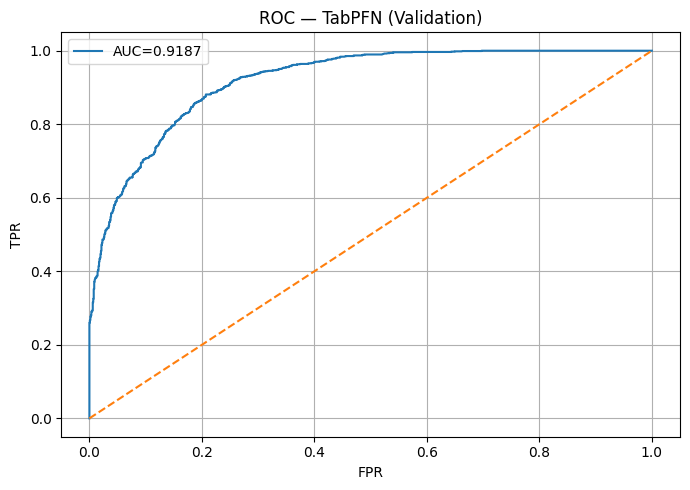

In [8]:
if yp_prob is not None and n_classes==2 and yp_prob.shape[1] >= 2:
    from sklearn.metrics import roc_curve
    fpr,tpr,_ = roc_curve(yva, yp_prob[:,1])
    auc = roc_auc_score(yva, yp_prob[:,1])
    plt.figure(figsize=(7,5)); plt.plot(fpr,tpr,label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC — TabPFN (Validation)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

## Save Model + Preprocessing

In [9]:
import joblib
os.makedirs("models", exist_ok=True)
safe_repo_id = re.sub(r'[^A-Za-z0-9_.-]+', '_', repo_id)

bundle = {
    "preprocessor": pre,       # fitted
    "model": clf_tabpfn,       # fitted TabPFNClassifier
    "target_name": TARGET_COLUMN_NAME,
    "label2id": label2id,
    "id2label": id2label,
    "numeric": NUMERIC_FEATURE_NAMES,
    "categorical": CATEGORICAL_FEATURE_NAMES
}
path = f"models/TabPFN_{safe_repo_id}.joblib"
joblib.dump(bundle, path)
print("Saved:", os.path.abspath(path))

Saved: /content/models/TabPFN_yuvalira_adult_income_balanced.joblib
